## calculate the Metabolic Index for each grid point at each depth for FOSI hindcast

In [1]:
import metabolic as mi
import xarray as xr
import numpy as np
import netCDF4
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.pyplot as plt

In [2]:
USER = os.environ['USER']
path = f'/glade/scratch/{USER}/DPLE-results'
filename = f'{path}/DPLE-FOSI_hindcast_T_S_O2_1948-2017_monthly.nc'
ds1 = xr.open_dataset(filename)
Temp = ds1['TEMP']
#
filename = f'{path}/DPLE-FOSI_hindcast_pO2_1948-2017_monthly.nc'
ds2 = xr.open_dataset(filename)
pO2 = ds2['pO2']
pO2

<xarray.DataArray 'pO2' (time: 840, z_t: 60, nlat: 384, nlon: 320)>
[6193152000 values with dtype=float32]
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    ULONG    (nlat, nlon) float64 ...
  * time     (time) object 0249-02-01 00:00:00 ... 0319-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

## Calculate Φ using 9 different combinations of Ac, Eo from Traits_db

In [3]:
import traits_db
from scipy import stats as scistats

In [4]:
def attrs_label(attrs): 
    """generate a label from long_name and units"""
    return f'{attrs["long_name"]} [{attrs["units"]}]'

In [5]:
df = traits_db.df_mi
df.head()

,Species,Ao,Ac,Eo
0,Acanthephyra acutifrons,26.809651,13.364732,-0.0278
1,Acanthephyra curtirostris,25.575448,14.364194,0.0380
2,Acanthephyra purpurea,23.310023,7.460879,0.1320
3,Acanthephyra smithi,28.985507,17.657939,-0.0301
5,Acipenser brevirostrum,22.123894,4.901716,0.3626


### Plot trait histograms

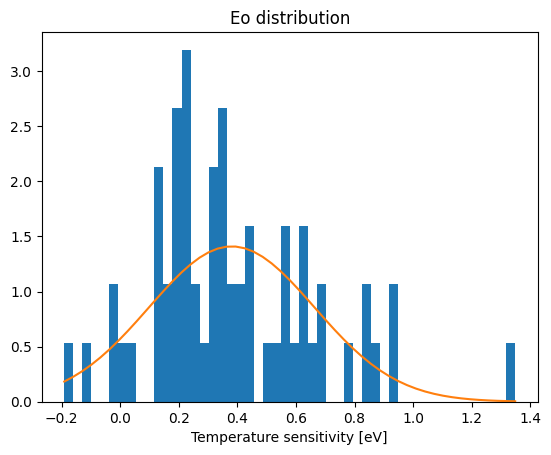

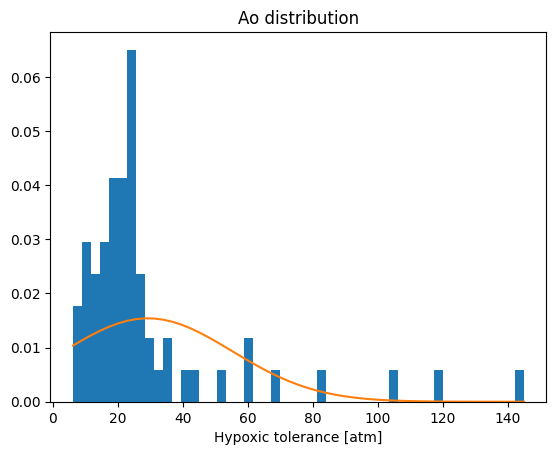

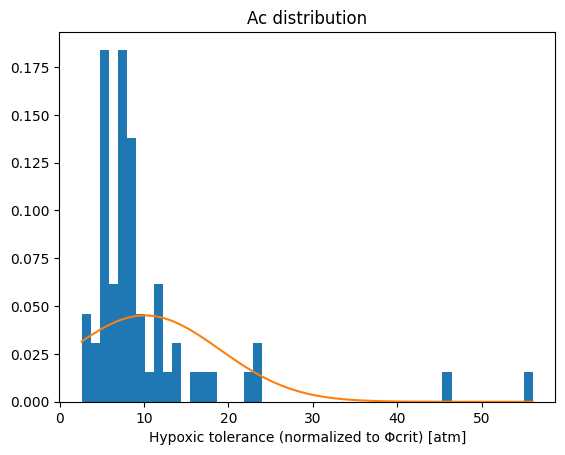

In [6]:
for vv in ['Eo','Ao','Ac']:
    fig, ax = plt.subplots()

    beta = scistats.norm.fit(df[vv].values)

    n, bins, h = ax.hist(df[vv].values, 50, density=True);
    pdf_fitted = scistats.norm.pdf(bins, *beta)
    ax.plot(bins, pdf_fitted)
    ax.set_title('%s distribution'%vv)
    ax.set_xlabel(attrs_label(df[vv].attrs));
plt.show()

In [7]:
Ac_dist = np.percentile(df.Ac, [25, 50, 75])
Ao_dist = np.percentile(df.Ao, [25, 50, 75])
Eo_dist = np.percentile(df.Eo, [25, 50, 75])
print(Ac_dist)
print(Ao_dist)
print(Eo_dist)

[ 5.56874234  7.34832416 10.87807731]
[16.69449082 22.22222222 26.88172043]
[0.1985 0.3389 0.5625]


### calculate Φ based on the 9 combinations

In [8]:
%%time
nrow = len(Ac_dist)
ncol = len(Eo_dist)
from itertools import product
dss = xr.Dataset()

for i, j in product(range(nrow), range(ncol)):
    Ac = Ac_dist[i]
    Eo = Eo_dist[j]
    print(Ac,Eo)
    dss[f'Phi_{3*i+j}'] = mi.Phi(pO2, Temp, Ac, Eo, dEodT=0.022)
    # = xr_reshape(ppphi,'time',['year','mon'],[np.arange(70),np.arange(12)]).mean(dim='mon')
dss

5.568742337410544 0.1985
5.568742337410544 0.3389
5.568742337410544 0.5625
7.3483241595629805 0.1985
7.3483241595629805 0.3389
7.3483241595629805 0.5625
10.878077312888639 0.1985
10.878077312888639 0.3389
10.878077312888639 0.5625
CPU times: user 10min 26s, sys: 35min 15s, total: 45min 41s
Wall time: 1h 21s


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 840, z_t: 60)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
  * time     (time) object 0249-02-01 00:00:00 ... 0319-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    Phi_0    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_1    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_2    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_3    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_4    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_5    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_6    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_7    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_8    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan

In [9]:
dout = f'/glade/scratch/{USER}/DPLE-results'
os.makedirs(dout, exist_ok=True)
dss.load()

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 840, z_t: 60)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
  * time     (time) object 0249-02-01 00:00:00 ... 0319-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    Phi_0    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_1    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_2    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_3    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_4    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_5    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_6    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_7    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    Phi_8    (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan

In [10]:
%%time
dss.to_netcdf(f'{dout}/DPLE-FOSI_hindcast_Phi_1948-2017_monthly.nc', mode='w')

CPU times: user 4.35 s, sys: 4min 13s, total: 4min 18s
Wall time: 29min 38s
